# Experiment 3. Тестирование различных моделей бустинга

В данном проекте мы будем тестировать несколько популярных видов бустинга, таких как:

- **XGBoost**: Один из самых популярных алгоритмов градиентного бустинга, который хорошо работает с большими наборами данных и имеет множество параметров для настройки.
- **CatBoost**: Алгоритм, разработанный для работы с категориальными признаками без необходимости их предварительной обработки. Он также хорошо справляется с дисбалансом классов.
- **LightGBM**: Эффективный алгоритм градиентного бустинга, который может обрабатывать большие объемы данных и поддерживает многопоточность. Он особенно полезен для работы с множественными колонками и может быть более быстрым, чем другие алгоритмы.

## Цель

Целью данного тестирования является определение наилучшей модели для нашей задачи, а также оценка их производительности с использованием метрики ROC AUC. Мы будем использовать различные методы обработки дисбаланса классов, такие как SMOTE, ADASYN и Tomek Links, чтобы улучшить качество моделей.

## Ход работы

1. **Загрузка данных**: Мы начнем с загрузки и предварительной обработки данных, чтобы подготовить их для обучения моделей.

2. **Разделение данных**: Данные будут разделены на обучающую и тестовую выборки, что позволит нам оценить производительность моделей на невидимых данных.

3. **Обучение моделей**: Мы обучим несколько моделей бустинга, включая:
   - **XGBoost**
   - **CatBoost**
   - **LightGBM**

4. **Оценка моделей**: Каждая модель будет оценена на тестовой выборке с использованием метрики ROC AUC. Мы будем сравнивать производительность моделей, чтобы определить, какая из них показывает наилучшие результаты.

5. **Выбор лучшей модели**: На основе полученных значений ROC AUC мы выберем модель с наивысшей производительностью.

6. **Обработка дисбаланса**: Мы протестируем различные методы обработки дисбаланса классов (такие как SMOTE, ADASYN и Tomek Links) на выбранной модели, чтобы улучшить ее производительность.

7. **Многократные итерации обучения**: Мы проведем множество итераций обучения на сбалансированных данных, чтобы оценить стабильность и надежность модели.

8. **Сравнение результатов**: Наконец, мы сравним результаты различных итераций обучения с помощью t-теста, чтобы определить, есть ли статистически значимые различия в производительности модели при использовании различных методов обработки дисбаланса.

## Заключение

В результате данного тестирования мы сможем определить, какая модель лучше всего подходит для нашей задачи, а также выявить, как методы обработки дисбаланса влияют на производительность моделей.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from utils.roc_auc import plot_roc_curve
from utils.model_comparison import run_model_iterations, compare_model_statistics

In [3]:
target_column = 'TARGET' 

In [4]:
data = pd.read_csv("./data/processed_data/processed_application_train.csv", index_col=0)
data.columns = data.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

In [5]:
# Определение целевой переменной и признаков
target_column = 'TARGET'  # Замените на имя вашей целевой переменной
X = data.drop(columns=[target_column])
y = data[target_column]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Настройка и обучение моделей

In [6]:
# 1. XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5, 7, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, len(y_train) / (2 * np.bincount(y_train)[1])]
}

xgb_grid_search = RandomizedSearchCV(xgb_model, xgb_param_grid, scoring='roc_auc', cv=3, n_jobs=6, n_iter=50)
xgb_grid_search.fit(X_train, y_train)

best_xgb_model = xgb_grid_search.best_estimator_
print("Лучшие параметры XGBoost:", xgb_grid_search.best_params_)

/Users/pelageya/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры XGBoost: {'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}


In [12]:
xgb_best_params = xgb_grid_search.best_params_
%store xgb_best_params

Stored 'xgb_best_params' (dict)


In [7]:
# 2. CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'depth': [2, 3, 5, 7, 11]
}

catboost_grid_search = RandomizedSearchCV(catboost_model, catboost_param_grid, scoring='roc_auc', cv=3, n_jobs=6, n_iter=50)
catboost_grid_search.fit(X_train, y_train)

best_catboost_model = catboost_grid_search.best_estimator_
print("Лучшие параметры CatBoost:", catboost_grid_search.best_params_)

Лучшие параметры CatBoost: {'learning_rate': 0.1, 'iterations': 300, 'depth': 5}


In [8]:
# 3. LightGBM
lgbm_model = LGBMClassifier(random_state=42)

lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 5, 7, 11],
    'class_weight': ['balanced', None]
}

lgbm_grid_search = RandomizedSearchCV(lgbm_model, lgbm_param_grid, scoring='roc_auc', cv=3, n_jobs=6, n_iter=50)
lgbm_grid_search.fit(X_train, y_train)

best_lgbm_model = lgbm_grid_search.best_estimator_
print("Лучшие параметры LightGBM:", lgbm_grid_search.best_params_)

[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11790
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

Выбираем лучшую модель

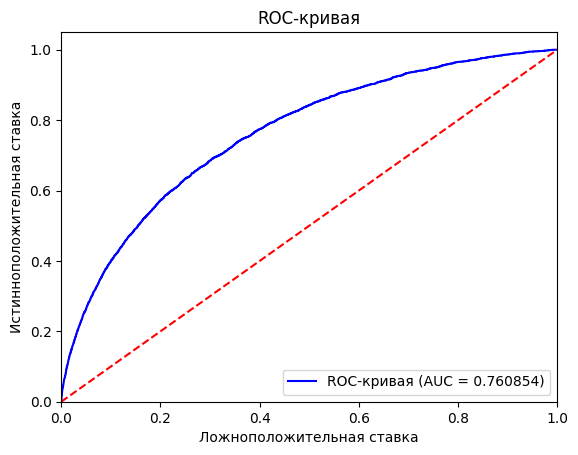

XGBoost ROC AUC: 0.7609


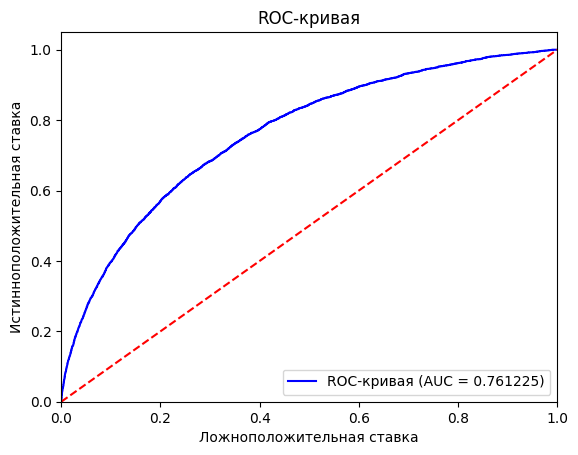

CatBoost ROC AUC: 0.7612


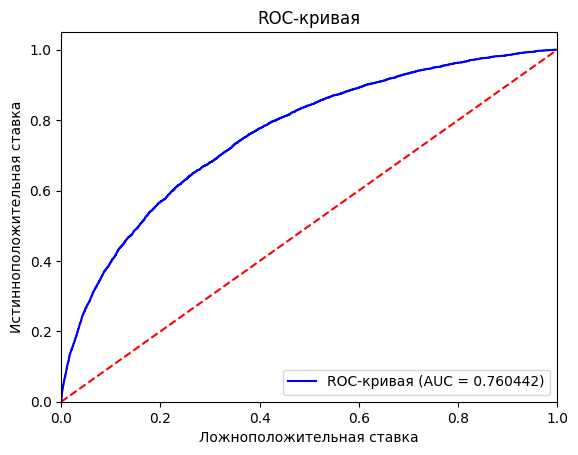

LightGBM ROC AUC: 0.7604
Лучшая модель: CatBoost с ROC AUC: 0.7612


In [9]:
models = {
    'XGBoost': best_xgb_model,
    'CatBoost': best_catboost_model,
    'LightGBM': best_lgbm_model
}

best_model_name = None
best_roc_auc = 0

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    
    roc_auc = plot_roc_curve(model, X_test, y_test)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = model_name

print(f"Лучшая модель: {best_model_name} с ROC AUC: {best_roc_auc:.4f}")

In [10]:
pipeline = Pipeline(steps=[
    ('model', models[best_model_name])
])

model3_roc_auc_distr = run_model_iterations(pipeline, X_train, y_train, X_test, y_test, n_iterations=100)

Training iterations:   0%|          | 0/100 [00:00<?, ?it/s]


CatBoostError: You can't change params of fitted model.

In [ ]:
%store model3_roc_auc_distr

Stored 'model3_roc_auc_distr' (ndarray)


In [ ]:
%store -r model1_roc_auc_distr

In [ ]:
compare_model_statistics(model1_roc_auc_distr, model3_roc_auc_distr)

Среднее ROC AUC Model 1: 0.6300391946362285
Среднее ROC AUC Model 2: 0.760853643622375
Модель 2 имеет большую метрику ROC AUC.
t-статистика: -3907885486257319.5
p-значение: 0.0
Существует статистически значимая разница между моделями.


/Users/pelageya/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


(-3907885486257319.5, 0.0)

Градиентый бустинг достаточно сильно и стат значимо повысил метрику